In [ ]:
import os
import math
from shutil import copyfile
from copy import copy
import tensorflow as tf
import numpy as np
import pandas as pd
import regex as re

In [ ]:
!pip install datasets transformers[sentencepiece]
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/NLP')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/NLP

 example2.txt				     'kmeans_ncluster=3.pkl'
 gender_full_dataset_with_m3_bert_Apr22.pkl   saved_model
 gender_full_dataset_with_m3_March18.pkl


In [ ]:
data=pd.read_pickle("/content/gdrive/MyDrive/NLP/gender_full_dataset_with_m3_March18.pkl")
data['Bert_cluster_kmeans']=pd.read_pickle("kmeans_ncluster=3.pkl")

In [ ]:
data['Bert_cluster_kmeans'].unique()

array([0, 2, 1], dtype=int32)

In [ ]:
def clean_data(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

In [ ]:
data['cleaned text'] = data['text'].apply(clean_data)

In [ ]:
cluster_list=[]
for i in range(3):
  cluster_list.append(data[data['Bert_cluster_kmeans']==i])

In [ ]:
data0=data[data['Bert_cluster_kmeans']==0]
data1=data[data['Bert_cluster_kmeans']==1]
data2=data[data['Bert_cluster_kmeans']==2]


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import InputExample, InputFeatures

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import tensorflow as tf
from tensorflow import keras

In [ ]:
class Tweets(Dataset):  
    def __init__(self, control_code, truncate=False, bert_type="bert-base-cased", max_length=1024):

        self.tokenizer = BertTokenizer.from_pretrained(bert_type)
        self.tweet = []

        for row in data['cleaned text']:
          self.tweet.append(torch.tensor(
                self.tokenizer.encode(f"<|{control_code}|>{row[:max_length]}<|endoftext|>")
            ))               
        if truncate:
            self.tweet = self.tweet[:20000]
        self.tweet_count = len(self.tweet)
        
    def __len__(self):
        return self.tweet_count

    def __getitem__(self, item):
        return self.tweet[item]
    
dataset = Tweets(data['cleaned text'], truncate=True, bert_type="bert-base-cased") 

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased', 
                                      num_labels=2,
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )

In [ ]:
test_set=['Jiashu Yang likes anime,', "Jiashu Yang hates salmon"]
#test_set=pd.DataFrame(test_set, columns=['prompt'])

In [ ]:
from tqdm import tqdm, trange
import torch.nn.functional as F

In [ ]:
from transformers import pipeline
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")



Downloading:   0%|          | 0.00/0.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji


In [ ]:
val=specific_model(test_set)

In [ ]:
val

[{'label': 'NEU', 'score': 0.6755080223083496},
 {'label': 'NEG', 'score': 0.9568799734115601}]

In [ ]:
test=cluster_list[0]['cleaned text'].sample(n=1000, random_state=1)
val=specific_model(test.to_list())

In [ ]:
test=cluster_list[1]['cleaned text'].sample(n=1000, random_state=1)
val1=specific_model(test.to_list())

In [ ]:
test=cluster_list[2]['cleaned text'].sample(n=1000, random_state=1)
val3=specific_model(test.to_list())

In [ ]:
len(lst)

0

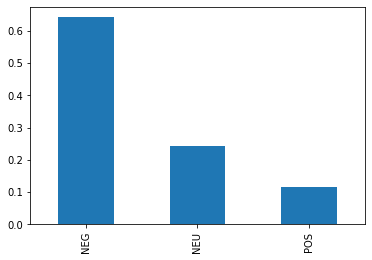

In [ ]:
val_0=pd.DataFrame(val3+val1+val)
val_0['label'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
with open('/content/gdrive/MyDrive/NLP/Example2.txt', 'w') as writefile:
    writefile.write(lst)